In [2]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.data.make_dataset import train_dataloader
from src.models.lit_node import NODE, ToyODE

Test on a sphere

In [3]:
def sphere_metric(theta, psi):
    return torch.tensor([[1, 0], [0, torch.sin(theta) ** 2]])
    

def polar_to_euc(mat):
    """mat (np.array): N X D
    N: number of observation in the path
    D: dimension (theta,psi)"""
    N, D = mat.shape
    coor = np.empty((N, 3))
    for i in range(N):
        theta, psi = mat[i, :]
        coor[i, :] = (
            np.sin(theta) * np.cos(psi),
            np.sin(theta) * np.sin(psi),
            np.cos(theta),
        )

    return coor

def euc_to_polar(mat):
    """mat (np.array) N X 3 return the corresponding polar coordinates."""
    N, _ = mat.shape
    coor = np.empty((N,2))
    for i in range(N):
        x,y,z = mat[i,:]
        coor[i,:] = (np.arctan((np.sqrt(x**2 + y**2)/z)), np.arctan(y/x))
    return coor

def great_circle(x0,x1,omega):
    """Great circle passing by `x0` and `x1`."""
    u = x0
    w = np.cross(x0,x1)
    w = w/np.linalg.norm(w)
    v = np.cross(u,w)

    return u*np.cos(omega) + v*np.sin(omega)

def path_interval(path):
    theta_min = 0 <= path[:,0].min()
    theta_max = path[:,0].max() <= pi
    theta = (theta_min and theta_max)
    psi_min = 0 <= path[:,1].min()
    psi_max = path[:,1].max() <= 2*pi
    psi = (psi_min and psi_max)

    return theta, psi

In [4]:
crzero = np.cross(np.array([1,2,3]),np.array([4,5,6]))
print(crzero)

[-3  6 -3]


In [14]:
x = 0 <= -1
y = 0 <= 1
print(x)
print(y)
print((x and y))

False
True
False


In [5]:
activation = "LeakyReLU" # Activation in between layers: Identity, LeakyReLU, ReLU, Tanh ...
fn_ode = ToyODE(2, [2,2], activation=activation)
neural_ode = NODE(fn_ode, method="rk4")

In [7]:
init = 0.0
end = pi
delta = end - init
x0 = torch.tensor([pi/4, init]).view(1, 2)
x1 = torch.tensor([pi/4, end]).view(1, 2)
#x0 = torch.tensor([init, 0.0]).view(1, 2)
#x1 = torch.tensor([end, 0.0]).view(1, 2)
x0_e = polar_to_euc(x0)
x1_e = polar_to_euc(x1)

print(x0)
print(x1)

tensor([[0.7854, 0.0000]])
tensor([[0.7854, 3.1416]])


In [5]:
n_epochs = 10 
n_steps = 100
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)

Loss:  tensor([1.9031], grad_fn=<PowBackward0>)
length:  tensor([1.3795], grad_fn=<DivBackward0>)


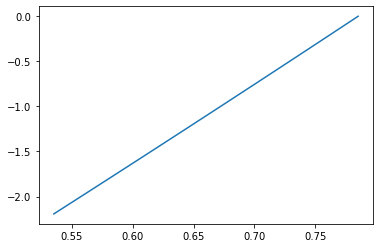

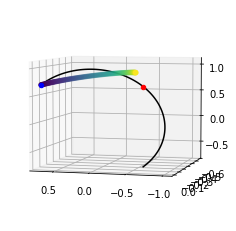

In [6]:
neural_ode.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps, end_time=end)
    x1_pred = path[-1]
    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    cost = []
    for idx, p0 in enumerate(neural_ode.path):
        c = torch.sqrt(p0 @ sphere_metric(path[idx,0,0], path[idx,0,1]) @ p0.T).squeeze(0) 
        #c = (p0 @ sphere_metric(path[idx,0,0], path[idx,0,1]) @ p0.T).squeeze(0) 
        cost.append(c)

    loss = (delta*sum(cost)/(n_steps-1))**2 #+ 100*pred_loss

 
    if epoch % 100 == 0:
        print("Loss: ", loss)
        print("length: ", delta * sum(cost)/(n_steps-1))
        plt.plot(path.detach().numpy()[:,0,0],path.detach().numpy()[:,0,1])
        plt.show()

        path_euc = polar_to_euc(path.squeeze(1).detach().numpy())
        geodesic = great_circle(x0_e,x1_e,np.linspace(init,-end,100).reshape(100,1))

        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
        ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
        ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')
        ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], c="black")
        ax.view_init(5, 105)
        plt.show()

    loss.backward()
    optimizer.step()

# TODO: difference between angles in curve and great circle
# TODO: 

In [107]:
for p in neural_ode.parameters():
    print(p.grad)

tensor([[-0.0068,  0.0048,  0.0200],
        [-0.7265,  0.5160,  2.1600]])
tensor([0.0079, 0.8688])
tensor([[-3.1777e-03,  1.3146e+00],
        [ 1.2368e-04, -4.1961e-02]])
tensor([ 1.3151, -0.0686])
tensor([[-1.1484e+01,  7.2284e-02],
        [ 1.8529e+00, -6.9816e-03]])
tensor([-13.9337,   1.6913])


In [78]:
neural_ode.eval()
path = neural_ode(x0, n_steps, end_time=end).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())
geodesic = great_circle(x0_e,x1_e,np.linspace(init,-end,100).reshape(100,1))

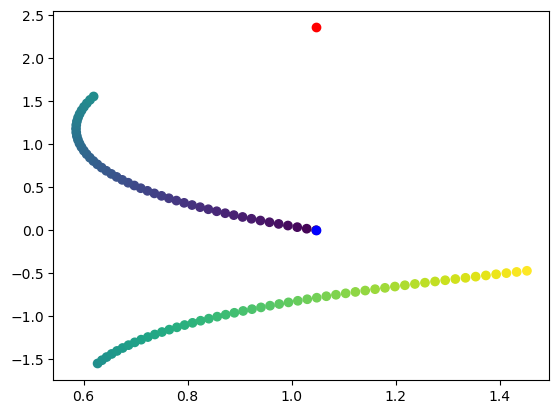

In [87]:
geodesic_polar = euc_to_polar(geodesic)
plt.scatter(geodesic_polar[:,0],geodesic_polar[:,1], c=list(range(geodesic_polar.shape[0])))
plt.scatter(x0[0,0],x0[0,1], c="blue")
plt.scatter(x1[0,0],x1[0,1], c="red")

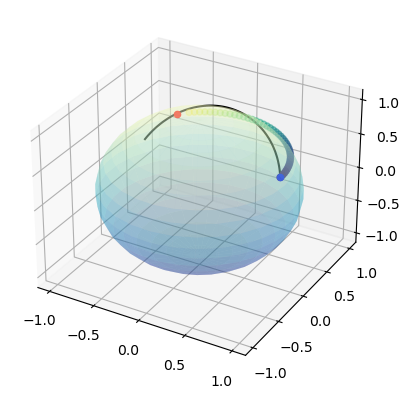

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], c="black")
plt.show()

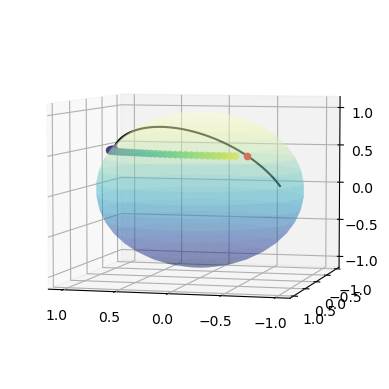

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.view_init(5, 105)
ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], c="black")
plt.show()

In [48]:

# Without the metric loss.
fn_ode = ToyODE(2, [20, 10, 10], activation=activation)
neural_ode = NODE(fn_ode, method="rk4")

n_epochs = 200
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)

neural_ode.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps, end_time=end).squeeze(1)

    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    loss = pred_loss

    if epoch % 200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(4.6122, grad_fn=<MseLossBackward0>)


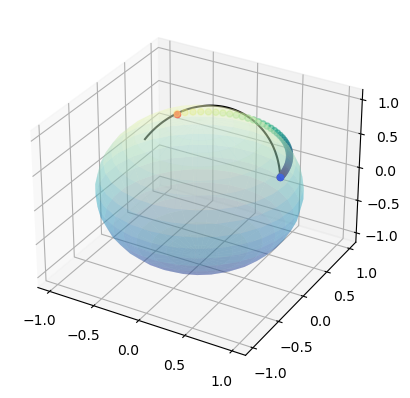

In [49]:
path_euc = polar_to_euc(path.detach().numpy())

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')

u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], c="black")
plt.show()

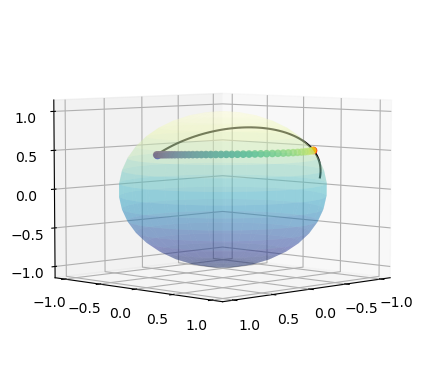

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')

u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], c="black")
ax.view_init(5, 45)
plt.show()

In [66]:
path[:,1].max()

tensor(2.3536, grad_fn=<MaxBackward1>)

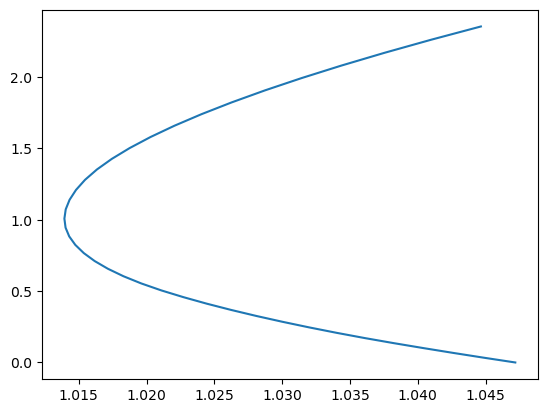

In [51]:
plt.plot(path.detach().numpy()[:,0],path.detach().numpy()[:,1])

### Hyperbolic space for the parameters of a Gaussian.

In [94]:
def fim_metric(position):
    """fim metric at the position torch.tensor((mu,sigma)): 1 x 2"""
    sigma = position[0,1]
    I_0 = 1/(sigma**2)
    I_1 = 2/(sigma**2)
    
    return torch.tensor([[I_0,0.0],[0.0,I_1]])


In [104]:
SEED=110
activation = "LeakyReLU" #Tanh, ReLU, Identity, LeakyReLU
torch.manual_seed(SEED)
fn_ode = ToyODE(2, [5,5],activation=activation) 
neural_ode = NODE(fn_ode, method="rk4")

In [105]:
# Geodesic between two point in Hyperbolic space
delta = 5.0
x0 = torch.tensor([0.0,1.0]).view(1,2)
x1 = torch.tensor([delta,1.0]).view(1,2)
n_epochs = 1500
n_steps = 30
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(params=neural_ode.parameters(), lr=0.0001)

In [106]:
neural_ode.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps, end_time=delta)
    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    cost = []
    n = len(neural_ode.path)
    for idx, p0 in enumerate(neural_ode.path):
        
        c = torch.sqrt(p0 @ fim_metric(path[idx,:]) @ p0.T).squeeze(0) 
        cost.append(c)
        

    loss = delta*sum(cost)/(n-1) + 20 * pred_loss
 
    if epoch % 100 == 0:
        print("Loss: ", loss)
        print("length: ", delta * sum(torch.sqrt(torch.tensor(cost)))/len(cost))

    loss.backward()
    optimizer.step()

Loss:  tensor([172.5899], grad_fn=<AddBackward0>)
length:  tensor(7.4009)
Loss:  tensor([17.7855], grad_fn=<AddBackward0>)
length:  tensor(6.5205)
Loss:  tensor([6.7227], grad_fn=<AddBackward0>)
length:  tensor(5.6281)
Loss:  tensor([6.7040], grad_fn=<AddBackward0>)
length:  tensor(5.6216)
Loss:  tensor([6.6646], grad_fn=<AddBackward0>)
length:  tensor(5.6051)
Loss:  tensor([6.6213], grad_fn=<AddBackward0>)
length:  tensor(5.5868)
Loss:  tensor([6.5753], grad_fn=<AddBackward0>)
length:  tensor(5.5674)
Loss:  tensor([6.5271], grad_fn=<AddBackward0>)
length:  tensor(5.5470)
Loss:  tensor([6.4773], grad_fn=<AddBackward0>)
length:  tensor(5.5258)
Loss:  tensor([6.4252], grad_fn=<AddBackward0>)
length:  tensor(5.5035)
Loss:  tensor([6.3695], grad_fn=<AddBackward0>)
length:  tensor(5.4796)
Loss:  tensor([6.3104], grad_fn=<AddBackward0>)
length:  tensor(5.4539)
Loss:  tensor([6.2518], grad_fn=<AddBackward0>)
length:  tensor(5.4284)
Loss:  tensor([6.1922], grad_fn=<AddBackward0>)
length:  tens

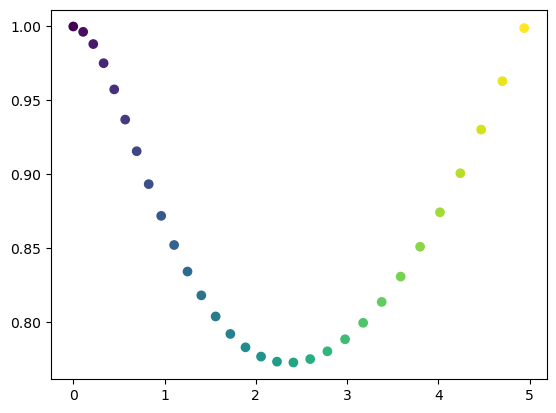

In [107]:
path_metric = neural_ode(x0, n_steps, end_time=delta).squeeze(1).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(path_metric[:, 0], path_metric[:, 1], c=list(range(n_steps)))
plt.show()

In [108]:
# Training without the FIM, i.e. only with the prediction of x1.
torch.manual_seed(SEED)
fn_ode = ToyODE(2, [10,10],activation=activation) # Tanh, 
neural_ode = NODE(fn_ode, method="rk4")

# Geodesic between two point in Hyperbolic space
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)

neural_ode.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps, end_time=delta)
    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    loss = 1 * pred_loss

 
    if epoch % 100 == 0:

        n = len(neural_ode.path)
        for idx, p0 in enumerate(neural_ode.path):
        
            c = torch.sqrt(p0 @ fim_metric(path[idx,:]) @ p0.T).squeeze(0) 
            cost.append(c)
        
        print("Loss: ", loss)
        print("length: ", delta * sum(cost)/len(cost))

    loss.backward()
    optimizer.step()


Loss:  tensor(26.4068, grad_fn=<MulBackward0>)
length:  tensor([10.5654], grad_fn=<DivBackward0>)
Loss:  tensor(0.5379, grad_fn=<MulBackward0>)
length:  tensor([8.5100], grad_fn=<DivBackward0>)
Loss:  tensor(1.5553e-06, grad_fn=<MulBackward0>)
length:  tensor([7.8467], grad_fn=<DivBackward0>)
Loss:  tensor(6.3335e-07, grad_fn=<MulBackward0>)
length:  tensor([7.4486], grad_fn=<DivBackward0>)
Loss:  tensor(4.5213e-07, grad_fn=<MulBackward0>)
length:  tensor([7.1828], grad_fn=<DivBackward0>)
Loss:  tensor(3.4468e-07, grad_fn=<MulBackward0>)
length:  tensor([6.9926], grad_fn=<DivBackward0>)
Loss:  tensor(2.7179e-07, grad_fn=<MulBackward0>)
length:  tensor([6.8496], grad_fn=<DivBackward0>)
Loss:  tensor(2.2161e-07, grad_fn=<MulBackward0>)
length:  tensor([6.7382], grad_fn=<DivBackward0>)
Loss:  tensor(1.8370e-07, grad_fn=<MulBackward0>)
length:  tensor([6.6488], grad_fn=<DivBackward0>)
Loss:  tensor(1.5487e-07, grad_fn=<MulBackward0>)
length:  tensor([6.5754], grad_fn=<DivBackward0>)
Loss: 

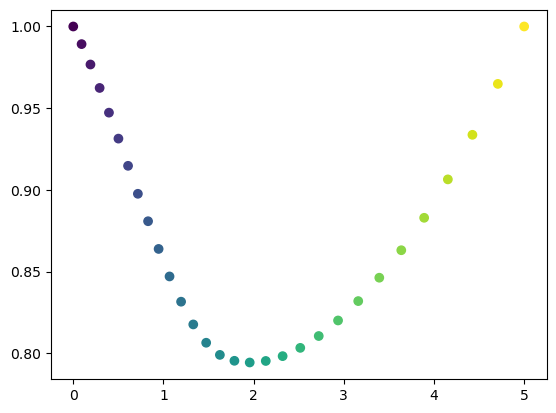

In [109]:
path_mse = neural_ode(x0, n_steps, end_time=delta).squeeze(1).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(path_mse[:, 0], path_mse[:, 1], c=list(range(n_steps)))
plt.show()

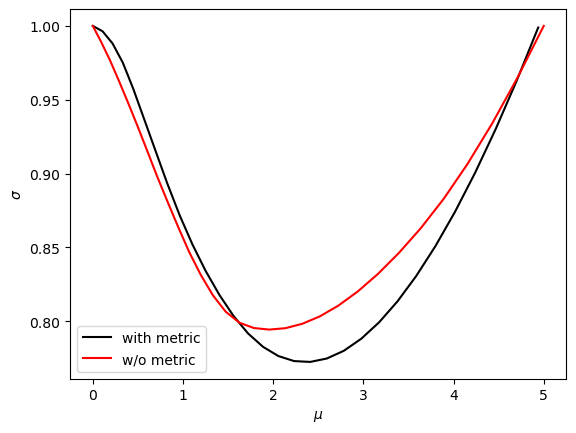

In [110]:
plt.plot(*path_metric.T, c="black")
plt.plot(*path_mse.T, c="red")
plt.legend(["with metric","w/o metric"])
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.show()

# Training on a batch

In [63]:
def sphere_metric(mat):
    batch_size, dim = mat.shape
    metric = torch.empty((batch_size,2,2))
    for i in range(batch_size):
        metric[i] = torch.tensor([[1, 0], [0, torch.sin(mat[i,1]) ** 2]])
    return metric

In [92]:
activation = "Identity" # Activation in between layers: Identity, LeakyReLU, ReLU, Tanh ...
fn_ode = ToyODE(2, [20,20], activation=activation)
neural_ode = NODE(fn_ode, method="rk4")
batch_size = 200
noise_scale = 0.05
n_steps=10

In [93]:
n_epochs = 1000
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)

In [94]:
init = 0.0
end = pi
delta = end - init
x0 = torch.tensor([pi/4, init]).view(1, 2)
x1 = torch.tensor([pi/4, end]).view(1, 2)
#x0 = torch.tensor([init, 0.0]).view(1, 2)
#x1 = torch.tensor([end, 0.0]).view(1, 2)
x0_e = polar_to_euc(x0)
x1_e = polar_to_euc(x1)

Loss:  tensor(57.6785, grad_fn=<AddBackward0>)
length:  tensor(0.0131, grad_fn=<MeanBackward0>)


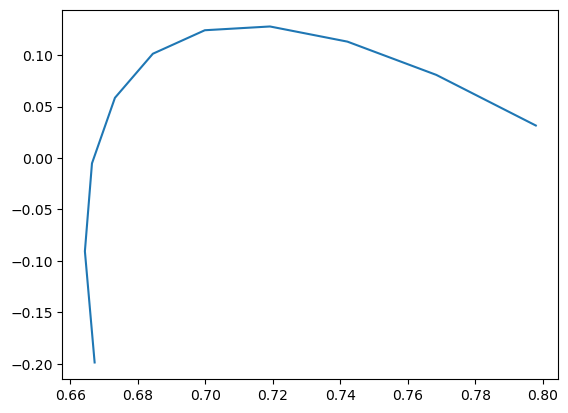

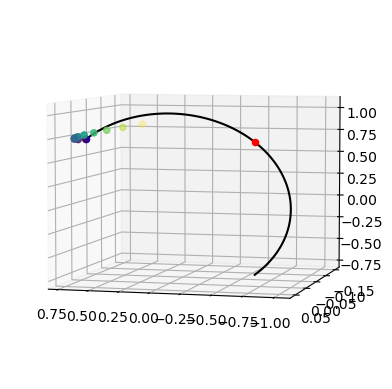

Loss:  tensor(1.8341, grad_fn=<AddBackward0>)
length:  tensor(1.6789, grad_fn=<MeanBackward0>)


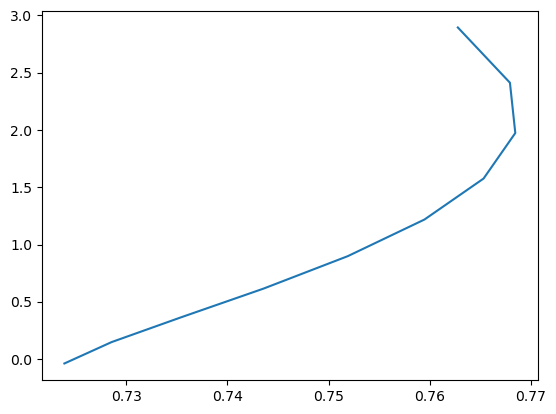

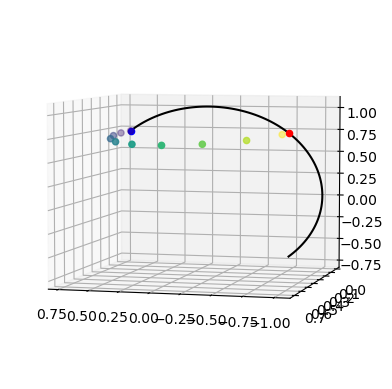

Loss:  tensor(1.7920, grad_fn=<AddBackward0>)
length:  tensor(1.6520, grad_fn=<MeanBackward0>)


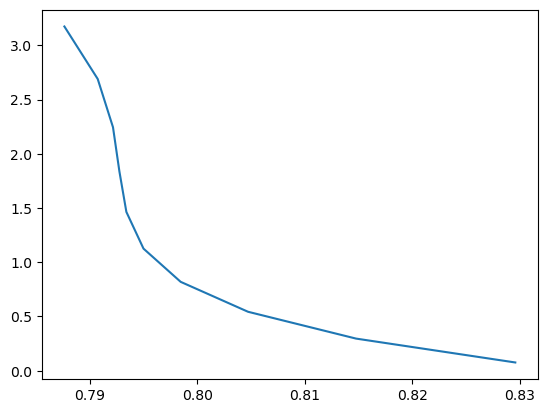

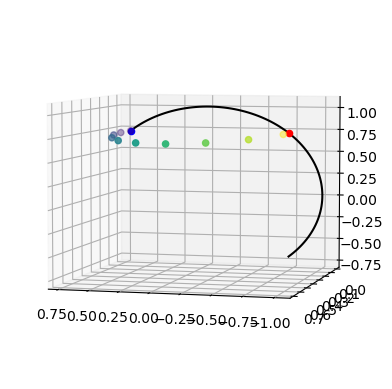

Loss:  tensor(1.7485, grad_fn=<AddBackward0>)
length:  tensor(1.6178, grad_fn=<MeanBackward0>)


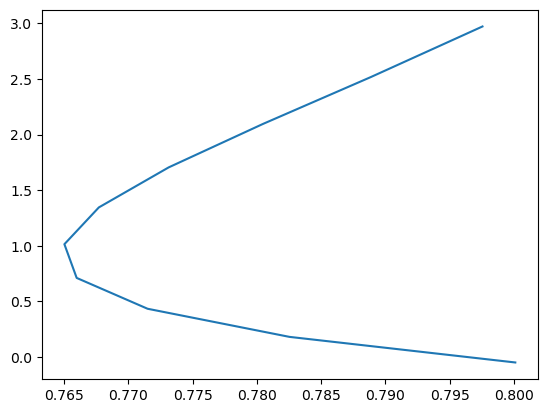

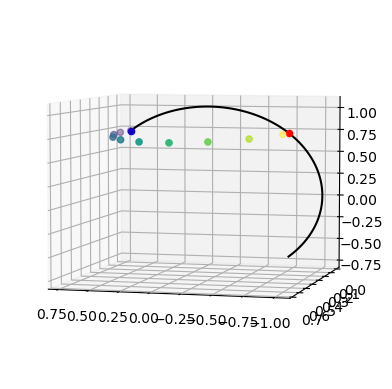

Loss:  tensor(1.7112, grad_fn=<AddBackward0>)
length:  tensor(1.5870, grad_fn=<MeanBackward0>)


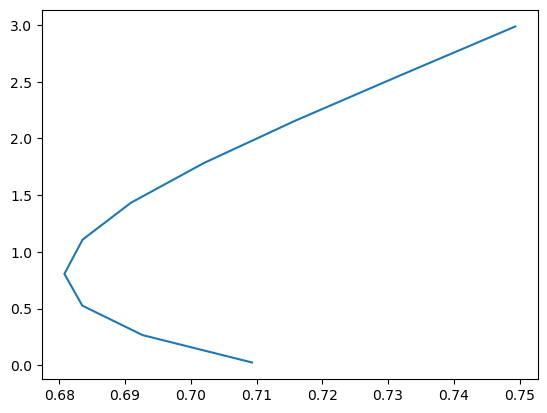

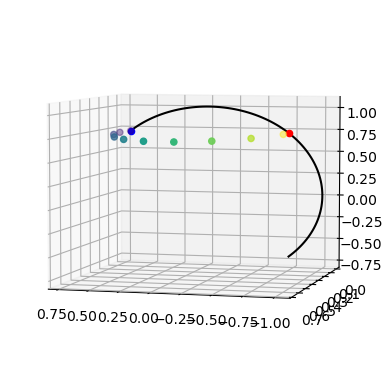

Loss:  tensor(1.6812, grad_fn=<AddBackward0>)
length:  tensor(1.5660, grad_fn=<MeanBackward0>)


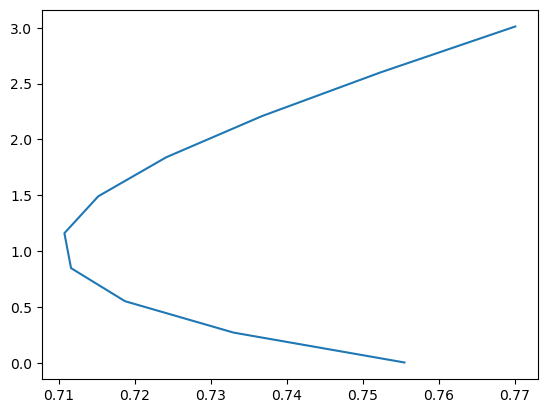

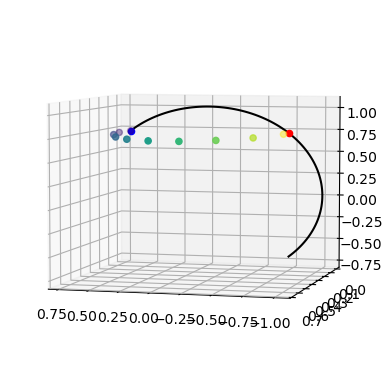

Loss:  tensor(1.6597, grad_fn=<AddBackward0>)
length:  tensor(1.5416, grad_fn=<MeanBackward0>)


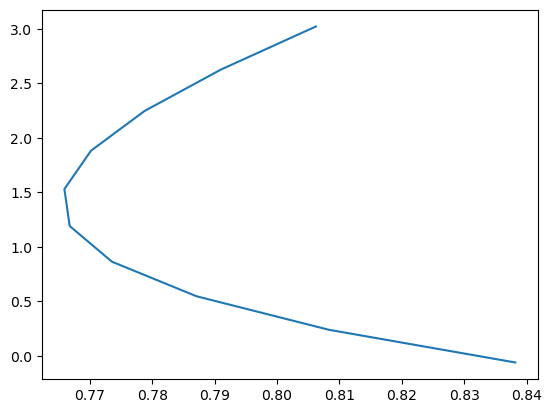

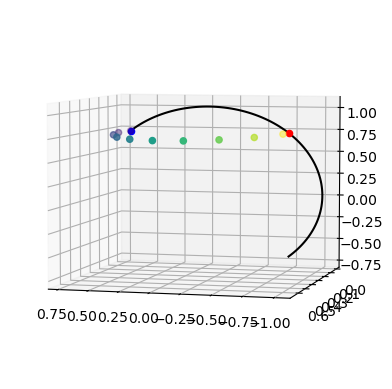

Loss:  tensor(1.6252, grad_fn=<AddBackward0>)
length:  tensor(1.5287, grad_fn=<MeanBackward0>)


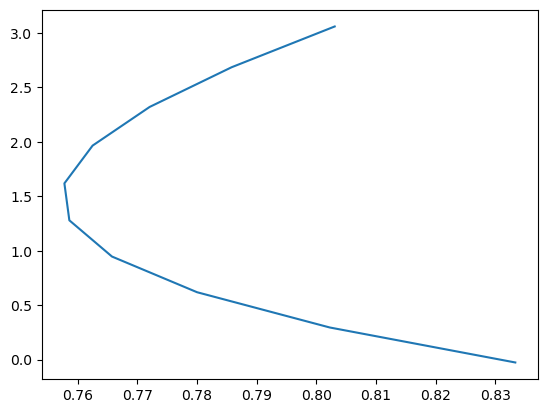

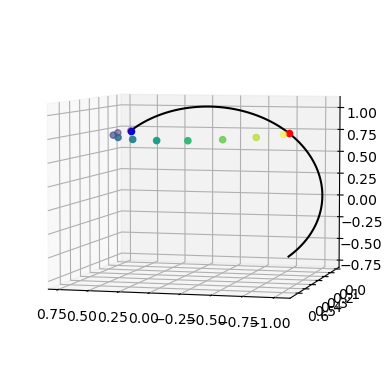

Loss:  tensor(1.6272, grad_fn=<AddBackward0>)
length:  tensor(1.5248, grad_fn=<MeanBackward0>)


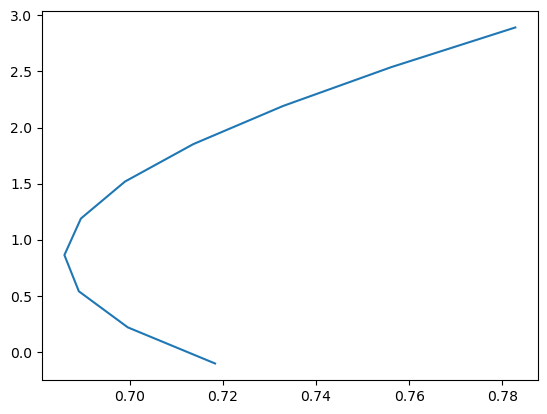

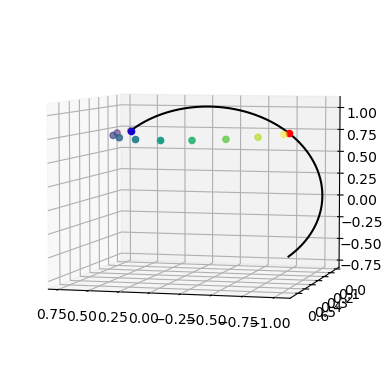

Loss:  tensor(1.6291, grad_fn=<AddBackward0>)
length:  tensor(1.5170, grad_fn=<MeanBackward0>)


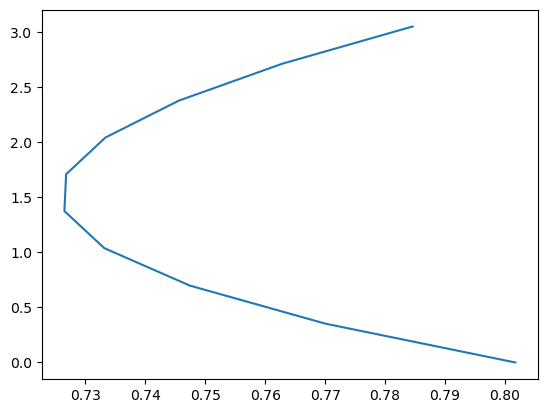

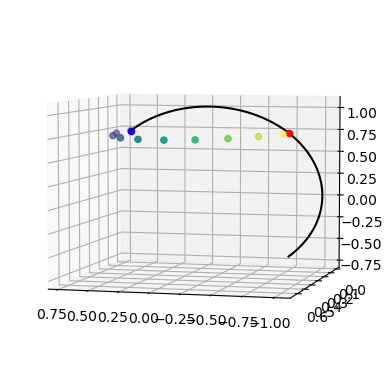

In [95]:
for epoch in range(n_epochs):
    optimizer.zero_grad()

    noise = torch.randn((batch_size,x0.shape[1]))
    batch0= x0 + noise_scale*noise
    noise = torch.randn((batch_size,x1.shape[1]))
    batch1 = x1 + noise_scale*noise

    path = neural_ode(batch0, n_steps, end_time=end)
    pred = path[-1]

    pred_loss = torch.nn.MSELoss()(pred, batch1)

    cost = []
    for idx, p0 in enumerate(neural_ode.path):
        c = torch.matmul(torch.matmul(p0.unsqueeze(1),sphere_metric(path[idx])),p0.unsqueeze(1).transpose(1,2)).squeeze(-1)
        cost.append(c)
    loss = torch.mean((delta * sum(cost)/(n_steps-1))) + 10*pred_loss

    if epoch % 100 == 0:
        print("Loss: ", loss)
        print("length: ", torch.mean(delta * sum(cost)/(n_steps-1)))
        plt.plot(path.detach().numpy()[:,0,0],path.detach().numpy()[:,0,1])
        plt.show()

        path = neural_ode(x0, n_steps, end_time=end)

        path_euc = polar_to_euc(path.squeeze(1).detach().numpy())
        geodesic = great_circle(x0_e,x1_e,np.linspace(init,-end,100).reshape(100,1))

        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
        ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
        ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')
        ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], c="black")
        ax.view_init(5, 105)
        plt.show()

    loss.backward()
    optimizer.step()


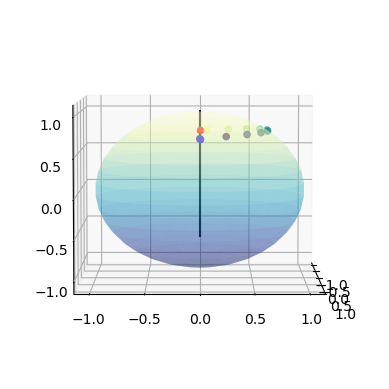

In [97]:
neural_ode.eval()
path = neural_ode(x0, n_steps, end_time=end).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())
geodesic = great_circle(x0_e,x1_e,np.linspace(init,-end,100).reshape(100,1))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.view_init(5, 0)
ax.plot(geodesic[:,0],geodesic[:,1],geodesic[:,2], c="black")
plt.show()